# Imports

In [24]:
import matplotlib.pyplot as plt

import torch
import torch.fft
import torchvision
import torchvision.transforms as transforms

from src.data.tiny_imagenet_dataset import SmallImageNetTrainDataset

# Data

In [25]:
image_size = 512

In [26]:
transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = SmallImageNetTrainDataset(
        root_dir=r"F:\\research\data\\small_imagenet_object_loc\\train",
        classes_names_path=r"F:\\research\\data\\small_imagenet_object_loc\\classes_names.txt",
        transform=transform
)

In [27]:
sample = dataset[2390]
image = sample["image"]
label = sample["label_encoded"]
image_tag = sample["tag"]

In [28]:
image.shape, label

(torch.Size([3, 512, 512]), 23)

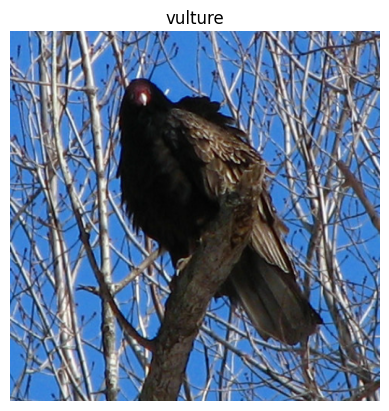

In [29]:
plt.title(f"{dataset.classes_names[image_tag]}")
plt.axis('off')
plt.imshow(image.permute(1, 2, 0).cpu().numpy(), cmap="gray" if image.shape[0] == 1 else None)

# FFT

In [30]:
def compute_fft(image):
    fft_image = torch.fft.fft2(image)
    fft_image_shifted = torch.fft.fftshift(fft_image)
    return fft_image_shifted

In [31]:
def apply_low_pass_filter(fft_image_shifted, filter_size, norm_type='l2'):
    """
    
    :param fft_image_shifted: 
    :param filter_size: 
    :param norm_type: could be l2 or l-infinity
    :return: 
    """
    height, width = fft_image_shifted.shape[1], fft_image_shifted.shape[2]
    y, x = torch.meshgrid(torch.arange(0, height), torch.arange(0, width))

    center_y, center_x = height // 2, width // 2
    distance_x = torch.abs(x - center_x)
    distance_y = torch.abs(y - center_y)

    if norm_type == 'l2':
        distance = torch.sqrt(distance_x**2 + distance_y**2)
        low_pass_mask = distance <= filter_size
    elif norm_type == 'l-infinity':
        low_pass_mask = (distance_x <= filter_size) & (distance_y <= filter_size)
    else:
        raise ValueError("Invalid norm type. Choose 'l2' or 'l-infinity'.")

    low_pass_mask = low_pass_mask.to(torch.complex64)
    fft_filtered = fft_image_shifted * low_pass_mask
    return fft_filtered

In [32]:
def crop_fft_filtered(fft_filtered, filter_size):
    """
    Crops the fft_filtered tensor so that only the central region remains.

    This function assumes that the filter was applied with a given filter_size so that
    the nonzero elements of fft_filtered are contained in a central square of size
    (2 * filter_size) x (2 * filter_size).

    Args:
      fft_filtered (torch.Tensor): The FFT result after applying the low-pass filter, shape [C, H, W].
      filter_size (int): The parameter used in the filtering, defining half the side length of the cropping square.
    
    Returns:
      torch.Tensor: The cropped FFT tensor with shape [C, 2 * filter_size, 2 * filter_size].
    """
    # Get the dimensions
    _, H, W = fft_filtered.shape
    center_y, center_x = H // 2, W // 2

    # Crop a central square: from center - filter_size to center + filter_size.
    cropped_fft = fft_filtered[:, center_y - filter_size:center_y + filter_size,
                                     center_x - filter_size:center_x + filter_size]
    return cropped_fft

In [33]:
def restore_image_from_fft(fft_filtered):
    fft_filtered_shifted_back = torch.fft.ifftshift(fft_filtered) 
    reconstructed_image = torch.fft.ifft2(fft_filtered_shifted_back)
    return torch.abs(reconstructed_image)

In [34]:
def compute_power_spectrum(fft_tensor):
    """
    Calculates the power spectrum of an FFT tensor.

    The power spectrum is defined as the squared magnitude of the FFT coefficients.
    The result is returned as a float32 tensor.

    Args:
      fft_tensor (torch.Tensor): A complex FFT tensor.
    
    Returns:
      torch.Tensor: The power spectrum as a float32 tensor.
    """
    power_spec = (torch.abs(fft_tensor) ** 2).float()
    return power_spec

In [35]:
fft_image_shifted = compute_fft(image)

filter_size = 96  # Size of the low-pass filter
filtered_fft = apply_low_pass_filter(fft_image_shifted, filter_size, norm_type='l-infinity')

In [36]:
filtered_fft

tensor([[[-0.+0.j, -0.+0.j, -0.+0.j,  ..., -0.+0.j, 0.-0.j, 0.-0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., -0.+0.j, 0.-0.j, -0.+0.j],
         [0.+0.j, 0.-0.j, 0.-0.j,  ..., 0.+0.j, -0.+0.j, 0.-0.j],
         ...,
         [0.+0.j, 0.-0.j, 0.-0.j,  ..., 0.+0.j, -0.+0.j, 0.+0.j],
         [0.+0.j, -0.+0.j, 0.-0.j,  ..., 0.+0.j, -0.+0.j, -0.+0.j],
         [0.+0.j, 0.-0.j, -0.+0.j,  ..., -0.+0.j, 0.+0.j, 0.+0.j]],

        [[-0.+0.j, 0.-0.j, 0.+0.j,  ..., -0.+0.j, 0.+0.j, -0.+0.j],
         [0.+0.j, 0.+0.j, 0.-0.j,  ..., 0.+0.j, 0.-0.j, 0.+0.j],
         [0.+0.j, 0.-0.j, -0.+0.j,  ..., 0.+0.j, -0.+0.j, 0.+0.j],
         ...,
         [-0.+0.j, 0.-0.j, 0.-0.j,  ..., -0.+0.j, 0.+0.j, -0.+0.j],
         [0.+0.j, 0.+0.j, 0.-0.j,  ..., -0.+0.j, 0.-0.j, -0.+0.j],
         [0.+0.j, 0.+0.j, -0.+0.j,  ..., -0.+0.j, -0.+0.j, 0.+0.j]],

        [[0.+0.j, 0.-0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, -0.+0.j],
         [0.+0.j, -0.+0.j, 0.+0.j,  ..., -0.+0.j, 0.-0.j, 0.+0.j],
         [0.+0.j, 0.-0.j, 0.-

In [37]:
croped_filtered_fft = crop_fft_filtered(filtered_fft, filter_size)
croped_filtered_fft.shape

torch.Size([3, 192, 192])

In [38]:
reconstructed_image = restore_image_from_fft(filtered_fft)

In [39]:
reconstructed_image.shape

torch.Size([3, 512, 512])

## Visualise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.4902521e-06..1.0740254].


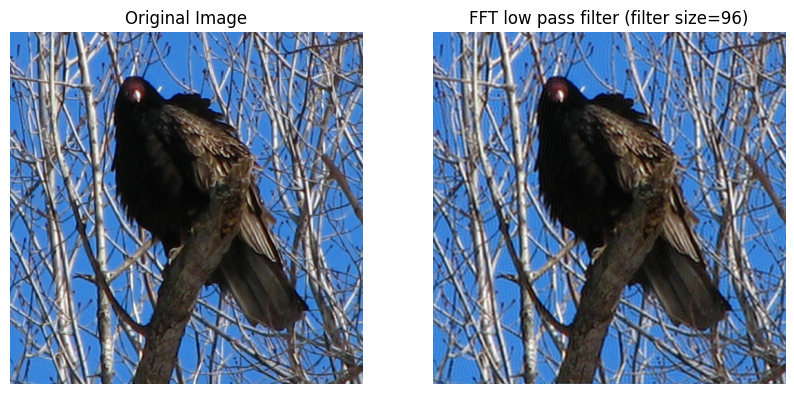

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image.permute(1, 2, 0).cpu().numpy(), cmap="gray" if image.shape[0] == 1 else None)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(reconstructed_image.permute(1, 2, 0).cpu().numpy(), cmap="gray" if image.shape[0] == 1 else None)
axes[1].set_title(f"FFT low pass filter (filter size={filter_size})")
axes[1].axis("off")

plt.show()

In [41]:
log_filtered_fft = torch.log(filtered_fft)
log_filtered_fft = torch.abs(log_filtered_fft).square().float()

In [42]:
im = log_filtered_fft[0].unsqueeze(0).permute(1, 2, 0).cpu().numpy()

In [43]:
im = 255 - im

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

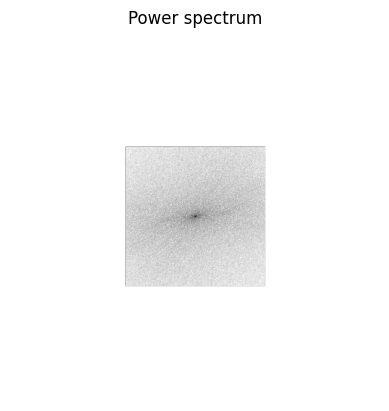

In [44]:
plt.imshow(im, cmap="gray")
plt.title("Power spectrum")
plt.axis("off")

# Tokenizer

In [23]:
from src.tokenizers.fft_tokenizer import FFTTokenizer

In [42]:
tokenizer = FFTTokenizer(
    image_size=image_size,
    num_channels=3,
    num_bins=16,
    embedding_dim=768,
    filter_size=96
) 

In [43]:
batch_size = 16

In [44]:
image_batch = torch.stack([image] * batch_size)
image_batch.shape

torch.Size([16, 3, 512, 512])

In [45]:
embeddings = tokenizer(image_batch)
embeddings.shape

torch.Size([16, 17, 768])

In [46]:
embeddings

tensor([[[-1.0265e+00, -1.0797e-01,  2.7113e-01,  ...,  1.5157e-01,
          -5.2953e+00,  3.3661e+00],
         [-1.7931e+03, -3.8411e+03,  4.6099e+03,  ..., -5.7502e+02,
          -1.6134e+02, -2.7438e+03],
         [-2.0439e+02,  1.2867e+02,  4.8756e+02,  ...,  3.1888e+01,
          -2.9927e+02, -3.1234e+02],
         ...,
         [ 1.9558e+01,  5.1669e+01,  4.5563e+01,  ...,  9.6583e+01,
          -1.1796e+02, -1.0607e+02],
         [-4.0289e+01,  1.5910e+02,  3.1994e+01,  ...,  3.4176e+01,
          -3.4176e+01, -9.0319e-01],
         [-4.2391e+01,  8.9035e+01, -8.2048e+00,  ...,  3.3701e+01,
          -6.3675e+01, -5.6104e+01]],

        [[-1.0265e+00, -1.0797e-01,  2.7113e-01,  ...,  1.5157e-01,
          -5.2953e+00,  3.3661e+00],
         [-1.7931e+03, -3.8411e+03,  4.6099e+03,  ..., -5.7502e+02,
          -1.6134e+02, -2.7438e+03],
         [-2.0439e+02,  1.2867e+02,  4.8756e+02,  ...,  3.1888e+01,
          -2.9927e+02, -3.1234e+02],
         ...,
         [ 1.9558e+01,  5

# Check random transforms

In [47]:
transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = SmallImageNetTrainDataset(
        root_dir=r"F:\\research\data\\small_imagenet_object_loc\\train",
        classes_names_path=r"F:\\research\\data\\small_imagenet_object_loc\\classes_names.txt",
        transform=transform
)

In [48]:
sample = dataset[2390]
image_base = sample["image"]
label = sample["label_encoded"]
image_tag = sample["tag"]

In [49]:
random_transform = transforms.Compose([
        transforms.Resize((
            int(image_size * 1.25),
            int(image_size * 1.25)
        )),
        transforms.RandomCrop(image_size),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize(
        #     mean=[0.485, 0.456, 0.406],
        #     std=[0.229, 0.224, 0.225]
        # ),
])

dataset_aug = SmallImageNetTrainDataset(
        root_dir=r"F:\\research\data\\small_imagenet_object_loc\\train",
        classes_names_path=r"F:\\research\\data\\small_imagenet_object_loc\\classes_names.txt",
        transform=random_transform
)

In [50]:
sample_aug = dataset_aug[2390]
image_aug = sample_aug["image"]
label_aug = sample_aug["label_encoded"]
image_tag_aug = sample_aug["tag"]

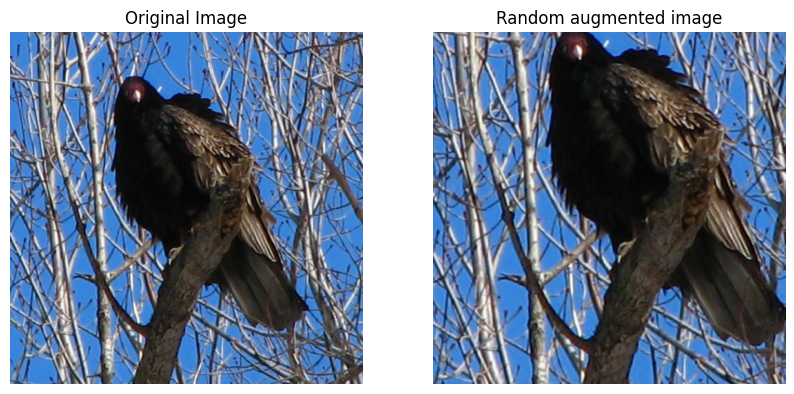

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image_base.permute(1, 2, 0).cpu().numpy(), cmap="gray" if image_base.shape[0] == 1 else None)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(image_aug.permute(1, 2, 0).cpu().numpy(), cmap="gray" if image_aug.shape[0] == 1 else None)
axes[1].set_title(f"Random augmented image")
axes[1].axis("off")

plt.show()

In [52]:
embeddings_base = tokenizer(image_base.unsqueeze(dim=0))
embeddings_aug = tokenizer(image_aug.unsqueeze(dim=0))

In [53]:
cos_sim = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

In [54]:
similarity = cos_sim(embeddings_base, embeddings_aug)
similarity.shape

torch.Size([1, 768])

In [55]:
similarity.abs().sum() / similarity.shape[1]

tensor(0.8885, grad_fn=<DivBackward0>)

In [57]:
embeddings_base.shape

torch.Size([1, 17, 768])

In [59]:
(embeddings_base - embeddings_aug).square().sum() / (embeddings_base.shape[0] * embeddings_base.shape[1] * embeddings_base.shape[2])

tensor(40094.4453, grad_fn=<DivBackward0>)